In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import copy
from copy import deepcopy
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
cpu = torch.device('cpu')
dv=torch.device('cuda')#torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchmetrics
acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)

In [2]:
from load_celebA import load_celeba

In [3]:
import time

In [ ]:
import torchvision.models as pretrain
model_pre=pretrain.resnet18(pretrained=True)

In [11]:
for par in model_pre.parameters():
    par.requires_grad=False


In [36]:
from model_class import MTL_vission,Branched_model_vission
from my_util import DM_rate, branches,fair_loss,find_groups,sim_mat,get_grads,fair_grads,get_conflicts
from my_util import get_task_heats

In [15]:
def trainFBvission(model_pre,dataset='CelebA',protected='Gender',tau=None,abalation=False,meta=False,clustering='agglomerative'):
    if dataset=='CelebA':
        dt,yt, gt, d_v, yv, gv,batch_size=load_celeba(protected=protected)
    else:
        print('Dataloader not found')
        return
    N_tasks=len(yt[0]) 
    
    dir_path='/yourpath/Grouping_FMTL/models/' #create a directory path to save parameters before running
    if abalation==True:
        dir_path=dir_path+'ablation/celeba/'+str(tau)
    prefix=dir_path+dataset+'_'+protected+'_'
    path=prefix+'fB.pt'
    path_br=prefix+'branches.pt'
    path_task=prefix+'task_layers.pt'
    path_sh=prefix+'sh_layers.pt'
    path_par=prefix+'parents.pt'
    path_pre=prefix+'pretrain.pt'
    
    shapes=[1024,128,256,512,128,64,256,128]
    depth=len(shapes)-1
    fb=nn.DataParallel(MTL_vission(pretrain=model_pre,tasks=N_tasks,shapes=shapes))
    fb.to(dv)
    opti_S=optim.AdamW(params=fb.parameters())
    criteria = nn.CrossEntropyLoss()
    
    parents={i:[] for i in range(N_tasks)}
    out=1
    branch_layers=nn.ModuleDict()
    groups=[[i for i in range(N_tasks)]]
    grouped={}
    
    
    fconflict_heats=torch.zeros(N_tasks,N_tasks)
    aconflict_heats=torch.zeros(N_tasks,N_tasks)
    fconflicts=[]
    aconflicts=[]
    abest,fbest= 10**5,10**5
    j=0
    for epoch in range(15):  # loop over each NN multiple times
        choices=list(np.arange(len(yt)))
        
        for k in range(len(yt)):
            
            ch=np.random.choice(choices)
            choices.remove(ch)
            dataloader,y_train,g_train=dt[ch],yt[ch],gt[ch]  #smaller batches of data to avoid memory issues
            y_train=[torch.tensor(y_train[i]) for i in range(N_tasks)]
            xg=torch.tensor(g_train)
            fb.to(dv)
            for i, data in enumerate(dataloader):
                inputs =data[0]
                if ((i+1)*batch_size)<len(g_train):            
                    labels=[y_train[t][i*batch_size:(i+1)*batch_size] for t in range(N_tasks)]
                    xc=xg[i*batch_size:(i+1)*batch_size]
                else:
                    labels=[y_train[t][i*batch_size:] for t in range(N_tasks)]
                    xc=xg[i*batch_size:]


                # zero the parameter gradients
                #net.load_state_dict(torch.load(path))  

                opti_S.zero_grad()
                outputs = fb(inputs.to(dv).float())
                if len(grouped)>0: #to be applied on branches after formation of branches
                    fb=fair_grads(fb,outputs,labels,xc,grouped,dv)
                for t in range(N_tasks):            
                    loss_a=criteria(outputs[t], labels[t].to(dv))            
                    loss_a.backward(retain_graph=True)
                opti_S.step()

            ch2=np.random.choice([0,1])
            val_batch,y_v,g_val=next(iter(d_v[ch2]))[0],yv[ch2],gv[ch2]
            #smaller batches of data to avoid memory issues
            
            if j<10:
                start = time.time()
            pred0=fb(val_batch.to(dv))
            task_grads=[]
            
            for t in range(N_tasks):
                loss_f=fair_loss(pred0[t], 
                                 torch.tensor(y_v[t]).to(dv),
                                 torch.tensor(g_val).to(dv))
                loss_f.backward(retain_graph=True)
                layer_grads,fb=get_grads(fb) #copy and clear the grad graph
                task_grads.append(deepcopy(layer_grads))           #
                del layer_grads
            fconflicts.append(get_conflicts(task_grads,N_tasks))
            fconflict_heats=get_task_heats(task_grads,fconflict_heats)
            cnf=[]
            for c in fconflicts[j]:
                cnf+=c 
            ln_f=len([v for v in cnf if v>90])
            if j<10:
                print(j,': ', f'Time: {time.time() - start}') #for monitoring time taken to compute conflicts
            task_grads=[]
            for t in range(N_tasks):
                loss=criteria(pred0[t], 
                                 torch.tensor(y_v[t]).to(dv))
                loss.backward(retain_graph=True)
                layer_grads,fb=get_grads(fb) #copy and clear the grad graph
                task_grads.append(deepcopy(layer_grads))           #
                del layer_grads
            aconflicts.append(get_conflicts(task_grads,N_tasks))
            aconflict_heats=get_task_heats(task_grads,aconflict_heats)
            cnf=[]
            for c in aconflicts[j]:
                cnf+=c 
            ln_a=len([v for v in cnf if v>90])
            if j<10:
                print(f'Time: {time.time() - start}')
            del task_grads
            opti_S.zero_grad() #empty parameter gradients
            
            cka_scores=sim_mat(fb,out)
            gps=find_groups(cka_scores,method=clustering,tau=tau)
            if j%3==0 and epoch>0 and out<=depth and len(gps)>=2:   #branching criteria
                groups=copy.deepcopy(gps)
                embeddor,shared_layers,branch_layers,task_layers,parents=branches(fb,groups,out,parents,
                                                                                  branch_layers,premod=True)
                grouped[out]=copy.deepcopy(gps)
                del fb
                #fb=nn.DataParallel(fb)
                
                fb=nn.DataParallel(Branched_model_vission(pretrain=embeddor,
                                        shared_all=shared_layers.to(cpu),branches=branch_layers.to(cpu),
                                       task_layers=task_layers.to(cpu),parents=parents,device=dv))
                fb.to(dv)
                opti_S=optim.AdamW(params=fb.parameters())
                out+=1

            if ln_f<=fbest and ln_a<=abest and len(groups)>2:
                fbest,abest=deepcopy(ln_f),deepcopy(ln_a)
                #print('checkpoint at: ',j)
                torch.save(branch_layers,path_br)
                torch.save(task_layers,path_task)
                torch.save(shared_layers,path_sh)
                torch.save(parents,path_par)
                torch.save(embeddor,path_pre)
                torch.save(fb.state_dict(),path)
            if meta==True:
                print('Epoch: ',j, 'Possible groups:', gps, 'at Layer', out)
                #print(cka_scores)
                for t in range(N_tasks):            
                    accuracy=acc(pred0[t].to(cpu),torch.tensor(y_v[t]))
                    EO=DM_rate(pred0[t].to(cpu),torch.tensor(y_v[t]).to(cpu),torch.tensor(g_val).to(cpu))  
                    print('Task',t,'  Acc:',accuracy, 'EO:',EO)
            j+=1
    torch.save(fconflicts,prefix+'conflicts.pt')
    torch.save(aconflicts,prefix+'aconflicts.pt')
    torch.save(fconflict_heats,prefix+'f_heat.pt')
    torch.save(aconflict_heats,prefix+'a_heat.pt')
    return fb,(fconflicts,aconflicts),(fconflict_heats,aconflict_heats)

In [8]:
fb,conflicts,heats=trainFBvission(model_pre,dataset='CelebA',protected='Gender')

0 :  Time: 0.5665624141693115
Time: 0.8869400024414062
Epoch:  0 Possible groups: [[0], [1], [2, 10], [3], [4], [5], [6], [7], [8], [9, 13], [11], [12], [14], [15], [16]] at Layer 1
Task 0   Acc: tensor(0.4794) EO: (tensor(0.0235), tensor(0.0124))
Task 1   Acc: tensor(0.7890) EO: (tensor(0.0198), tensor(0.0168))
Task 2   Acc: tensor(0.8506) EO: (tensor(0.0116), tensor(0.0086))
Task 3   Acc: tensor(0.8484) EO: (tensor(0.0182), tensor(0.0176))
Task 4   Acc: tensor(0.7483) EO: (tensor(0.0281), tensor(0.0232))
Task 5   Acc: tensor(0.7930) EO: (tensor(0.0057), tensor(0.0010))
Task 6   Acc: tensor(0.7575) EO: (tensor(0.0099), tensor(0.0043))
Task 7   Acc: tensor(0.8591) EO: (tensor(0.0134), tensor(0.0121))
Task 8   Acc: tensor(0.5491) EO: (tensor(0.0124), tensor(0.0026))
Task 9   Acc: tensor(0.5174) EO: (tensor(0.0324), tensor(0.0115))
Task 10   Acc: tensor(0.9227) EO: (tensor(0.0143), tensor(0.0132))
Task 11   Acc: tensor(0.7170) EO: (tensor(0.0157), tensor(0.0119))
Task 12   Acc: tensor(0.

7 :  Time: 0.5422518253326416
Time: 0.779099702835083
Epoch:  7 Possible groups: [[0], [1], [2], [3, 10], [4, 6], [5], [7], [8], [9], [11], [12], [13]] at Layer 2
Task 0   Acc: tensor(0.6723) EO: (tensor(0.0147), tensor(0.0110))
Task 1   Acc: tensor(0.7962) EO: (tensor(0.0093), tensor(0.0032))
Task 2   Acc: tensor(0.8560) EO: (tensor(0.0307), tensor(0.0259))
Task 3   Acc: tensor(0.8451) EO: (tensor(0.0130), tensor(0.0115))
Task 4   Acc: tensor(0.7541) EO: (tensor(0.0113), tensor(0.0013))
Task 5   Acc: tensor(0.7982) EO: (tensor(0.0079), tensor(0.0064))
Task 6   Acc: tensor(0.7600) EO: (tensor(0.0199), tensor(0.0145))
Task 7   Acc: tensor(0.8559) EO: (tensor(0.0169), tensor(0.0165))
Task 8   Acc: tensor(0.6438) EO: (tensor(0.0353), tensor(0.0162))
Task 9   Acc: tensor(0.5706) EO: (tensor(0.0068), tensor(0.0004))
Task 10   Acc: tensor(0.9271) EO: (tensor(0.0072), tensor(0.0027))
Task 11   Acc: tensor(0.7233) EO: (tensor(0.0039), tensor(0.0023))
Task 12   Acc: tensor(0.7143) EO: (tensor(0

Epoch:  14 Possible groups: [[0, 11], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [12]] at Layer 4
Task 0   Acc: tensor(0.6909) EO: (tensor(0.0124), tensor(0.0049))
Task 1   Acc: tensor(0.7918) EO: (tensor(0.0159), tensor(0.0140))
Task 2   Acc: tensor(0.8703) EO: (tensor(0.0106), tensor(0.0076))
Task 3   Acc: tensor(0.8496) EO: (tensor(0.0165), tensor(0.0151))
Task 4   Acc: tensor(0.7659) EO: (tensor(0.0176), tensor(0.0126))
Task 5   Acc: tensor(0.8301) EO: (tensor(0.0294), tensor(0.0199))
Task 6   Acc: tensor(0.7767) EO: (tensor(0.0230), tensor(0.0218))
Task 7   Acc: tensor(0.8611) EO: (tensor(0.0273), tensor(0.0245))
Task 8   Acc: tensor(0.6743) EO: (tensor(0.0064), tensor(0.0007))
Task 9   Acc: tensor(0.6109) EO: (tensor(0.0065), tensor(0.0027))
Task 10   Acc: tensor(0.9227) EO: (tensor(0.0143), tensor(0.0132))
Task 11   Acc: tensor(0.7195) EO: (tensor(0.0263), tensor(0.0204))
Task 12   Acc: tensor(0.7236) EO: (tensor(0.0437), tensor(0.0425))
Task 13   Acc: tensor(0.6671) EO:

Epoch:  21 Possible groups: [[0], [1, 2], [3], [4], [5], [6], [7], [8], [9], [10], [11]] at Layer 7
Task 0   Acc: tensor(0.6978) EO: (tensor(0.0100), tensor(0.0058))
Task 1   Acc: tensor(0.7902) EO: (tensor(0.0334), tensor(0.0301))
Task 2   Acc: tensor(0.8716) EO: (tensor(0.0024), tensor(0.0014))
Task 3   Acc: tensor(0.8496) EO: (tensor(0.0038), tensor(0.0007))
Task 4   Acc: tensor(0.7668) EO: (tensor(0.0113), tensor(0.0014))
Task 5   Acc: tensor(0.8217) EO: (tensor(0.0255), tensor(0.0173))
Task 6   Acc: tensor(0.7815) EO: (tensor(0.0099), tensor(0.0084))
Task 7   Acc: tensor(0.8620) EO: (tensor(0.0103), tensor(0.0079))
Task 8   Acc: tensor(0.6808) EO: (tensor(0.0101), tensor(0.0083))
Task 9   Acc: tensor(0.6191) EO: (tensor(0.0160), tensor(0.0131))
Task 10   Acc: tensor(0.9227) EO: (tensor(0.0143), tensor(0.0132))
Task 11   Acc: tensor(0.7232) EO: (tensor(0.0056), tensor(0.0030))
Task 12   Acc: tensor(0.7212) EO: (tensor(0.0300), tensor(0.0284))
Task 13   Acc: tensor(0.6745) EO: (tens

Epoch:  28 Possible groups: [[0], [1], [2], [3], [4], [5, 9], [6], [7], [8], [10]] at Layer 8
Task 0   Acc: tensor(0.7017) EO: (tensor(0.0299), tensor(0.0171))
Task 1   Acc: tensor(0.7905) EO: (tensor(0.0152), tensor(0.0152))
Task 2   Acc: tensor(0.8728) EO: (tensor(0.0093), tensor(0.0062))
Task 3   Acc: tensor(0.8501) EO: (tensor(0.0114), tensor(0.0090))
Task 4   Acc: tensor(0.7701) EO: (tensor(0.0244), tensor(0.0076))
Task 5   Acc: tensor(0.8280) EO: (tensor(0.0442), tensor(0.0332))
Task 6   Acc: tensor(0.7818) EO: (tensor(0.0113), tensor(0.0103))
Task 7   Acc: tensor(0.8635) EO: (tensor(0.0211), tensor(0.0196))
Task 8   Acc: tensor(0.6800) EO: (tensor(0.0192), tensor(0.0076))
Task 9   Acc: tensor(0.6227) EO: (tensor(0.0057), tensor(0.0025))
Task 10   Acc: tensor(0.9227) EO: (tensor(0.0143), tensor(0.0132))
Task 11   Acc: tensor(0.7148) EO: (tensor(0.0041), tensor(0.0008))
Task 12   Acc: tensor(0.7255) EO: (tensor(0.0264), tensor(0.0262))
Task 13   Acc: tensor(0.6735) EO: (tensor(0.0

Epoch:  35 Possible groups: [[0], [1, 3], [2], [4], [5], [6], [7], [8], [9], [10]] at Layer 8
Task 0   Acc: tensor(0.7009) EO: (tensor(0.0189), tensor(0.0151))
Task 1   Acc: tensor(0.7820) EO: (tensor(0.0119), tensor(0.0053))
Task 2   Acc: tensor(0.8801) EO: (tensor(0.0290), tensor(0.0289))
Task 3   Acc: tensor(0.8423) EO: (tensor(0.0101), tensor(0.0087))
Task 4   Acc: tensor(0.7631) EO: (tensor(0.0320), tensor(0.0315))
Task 5   Acc: tensor(0.8156) EO: (tensor(0.0147), tensor(0.0105))
Task 6   Acc: tensor(0.7819) EO: (tensor(0.0159), tensor(0.0127))
Task 7   Acc: tensor(0.8569) EO: (tensor(0.0251), tensor(0.0236))
Task 8   Acc: tensor(0.6716) EO: (tensor(0.0009), tensor(0.0002))
Task 9   Acc: tensor(0.6205) EO: (tensor(0.0371), tensor(0.0207))
Task 10   Acc: tensor(0.9271) EO: (tensor(0.0072), tensor(0.0027))
Task 11   Acc: tensor(0.7118) EO: (tensor(0.0050), tensor(0.0030))
Task 12   Acc: tensor(0.7130) EO: (tensor(0.0355), tensor(0.0282))
Task 13   Acc: tensor(0.6743) EO: (tensor(0.0

Epoch:  42 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]] at Layer 8
Task 0   Acc: tensor(0.6858) EO: (tensor(0.0264), tensor(0.0152))
Task 1   Acc: tensor(0.7618) EO: (tensor(0.0204), tensor(0.0158))
Task 2   Acc: tensor(0.8726) EO: (tensor(0.0262), tensor(0.0256))
Task 3   Acc: tensor(0.8196) EO: (tensor(0.0614), tensor(0.0515))
Task 4   Acc: tensor(0.7431) EO: (tensor(0.0049), tensor(0.0026))
Task 5   Acc: tensor(0.7966) EO: (tensor(0.0057), tensor(0.0047))
Task 6   Acc: tensor(0.7664) EO: (tensor(0.0281), tensor(0.0238))
Task 7   Acc: tensor(0.8413) EO: (tensor(0.0077), tensor(0.0056))
Task 8   Acc: tensor(0.6459) EO: (tensor(0.0408), tensor(0.0268))
Task 9   Acc: tensor(0.6100) EO: (tensor(0.0390), tensor(0.0249))
Task 10   Acc: tensor(0.9228) EO: (tensor(0.0079), tensor(0.0039))
Task 11   Acc: tensor(0.6802) EO: (tensor(0.0150), tensor(0.0090))
Task 12   Acc: tensor(0.6726) EO: (tensor(0.0112), tensor(0.0106))
Task 13   Acc: tensor(0.6609) EO: (tensor(0

Epoch:  49 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]] at Layer 8
Task 0   Acc: tensor(0.6739) EO: (tensor(0.0168), tensor(0.0116))
Task 1   Acc: tensor(0.7565) EO: (tensor(0.0171), tensor(0.0059))
Task 2   Acc: tensor(0.8572) EO: (tensor(0.0262), tensor(0.0208))
Task 3   Acc: tensor(0.7907) EO: (tensor(0.0050), tensor(0.0025))
Task 4   Acc: tensor(0.7394) EO: (tensor(0.0102), tensor(0.0043))
Task 5   Acc: tensor(0.8046) EO: (tensor(0.0146), tensor(0.0112))
Task 6   Acc: tensor(0.7616) EO: (tensor(0.0221), tensor(0.0157))
Task 7   Acc: tensor(0.8364) EO: (tensor(0.0007), tensor(0.0003))
Task 8   Acc: tensor(0.6430) EO: (tensor(0.0098), tensor(0.0050))
Task 9   Acc: tensor(0.5963) EO: (tensor(0.0114), tensor(0.0014))
Task 10   Acc: tensor(0.9006) EO: (tensor(0.0116), tensor(0.0091))
Task 11   Acc: tensor(0.6589) EO: (tensor(0.0171), tensor(0.0160))
Task 12   Acc: tensor(0.6752) EO: (tensor(0.0187), tensor(0.0184))
Task 13   Acc: tensor(0.6386) EO: (tensor(0

Epoch:  56 Possible groups: [[0], [1, 3], [2], [4], [5], [6], [7], [8], [9], [10]] at Layer 8
Task 0   Acc: tensor(0.6759) EO: (tensor(0.0416), tensor(0.0270))
Task 1   Acc: tensor(0.7592) EO: (tensor(0.0117), tensor(0.0036))
Task 2   Acc: tensor(0.8628) EO: (tensor(0.0171), tensor(0.0147))
Task 3   Acc: tensor(0.7906) EO: (tensor(0.0336), tensor(0.0266))
Task 4   Acc: tensor(0.7392) EO: (tensor(0.0072), tensor(0.0008))
Task 5   Acc: tensor(0.7930) EO: (tensor(0.0206), tensor(0.0154))
Task 6   Acc: tensor(0.7676) EO: (tensor(0.0162), tensor(0.0128))
Task 7   Acc: tensor(0.8373) EO: (tensor(0.0266), tensor(0.0232))
Task 8   Acc: tensor(0.6439) EO: (tensor(0.0446), tensor(0.0290))
Task 9   Acc: tensor(0.6098) EO: (tensor(0.0392), tensor(0.0217))
Task 10   Acc: tensor(0.9003) EO: (tensor(0.0066), tensor(0.0019))
Task 11   Acc: tensor(0.6653) EO: (tensor(0.0067), tensor(0.0051))
Task 12   Acc: tensor(0.6674) EO: (tensor(0.0104), tensor(0.0070))
Task 13   Acc: tensor(0.6562) EO: (tensor(0.0

In [9]:
dataloader_test, y_test, g_test=load_celeba(protected='Gender',mode='test')

In [12]:
fb.to(dv)
test_batch=next(iter(dataloader_test))[0]
pred0=fb(test_batch.to(dv).float())
N_tasks=len(y_test)
for t in range(N_tasks):  
    accuracy=acc(pred0[t].to(cpu),torch.tensor(y_test[t]).to(cpu))
    EO=DM_rate(pred0[t].to(cpu),torch.tensor(y_test[t]).to(cpu),torch.tensor(g_test).to(cpu))
    print('Task',t,'  Acc:',accuracy, 'EO:',EO)

Task 0   Acc: tensor(0.7087) EO: (tensor(0.0335), tensor(0.0135))
Task 1   Acc: tensor(0.7887) EO: (tensor(0.0018), tensor(0.0017))
Task 2   Acc: tensor(0.8729) EO: (tensor(0.0264), tensor(0.0254))
Task 3   Acc: tensor(0.6811) EO: (tensor(0.0066), tensor(0.0054))
Task 4   Acc: tensor(0.7824) EO: (tensor(0.0322), tensor(0.0256))
Task 5   Acc: tensor(0.7929) EO: (tensor(0.0209), tensor(0.0145))
Task 6   Acc: tensor(0.8181) EO: (tensor(0.0052), tensor(0.0049))
Task 7   Acc: tensor(0.8672) EO: (tensor(0.0100), tensor(0.0043))
Task 8   Acc: tensor(0.6634) EO: (tensor(0.0244), tensor(0.0122))
Task 9   Acc: tensor(0.6095) EO: (tensor(0.0091), tensor(0.0086))
Task 10   Acc: tensor(0.8511) EO: (tensor(0.0087), tensor(0.0031))
Task 11   Acc: tensor(0.7008) EO: (tensor(0.0155), tensor(0.0062))
Task 12   Acc: tensor(0.7146) EO: (tensor(0.0055), tensor(0.0023))
Task 13   Acc: tensor(0.6622) EO: (tensor(0.0064), tensor(0.0036))
Task 14   Acc: tensor(0.7900) EO: (tensor(0.0189), tensor(0.0116))
Task 

In [5]:
dir_path='/yourpath/Grouping_FMTL/models/'
prefix=dir_path+'CelebA'+'_'+'Gender'+'_'
conflicts=torch.load(prefix+'conflicts.pt')
aconflicts=torch.load(prefix+'aconflicts.pt')

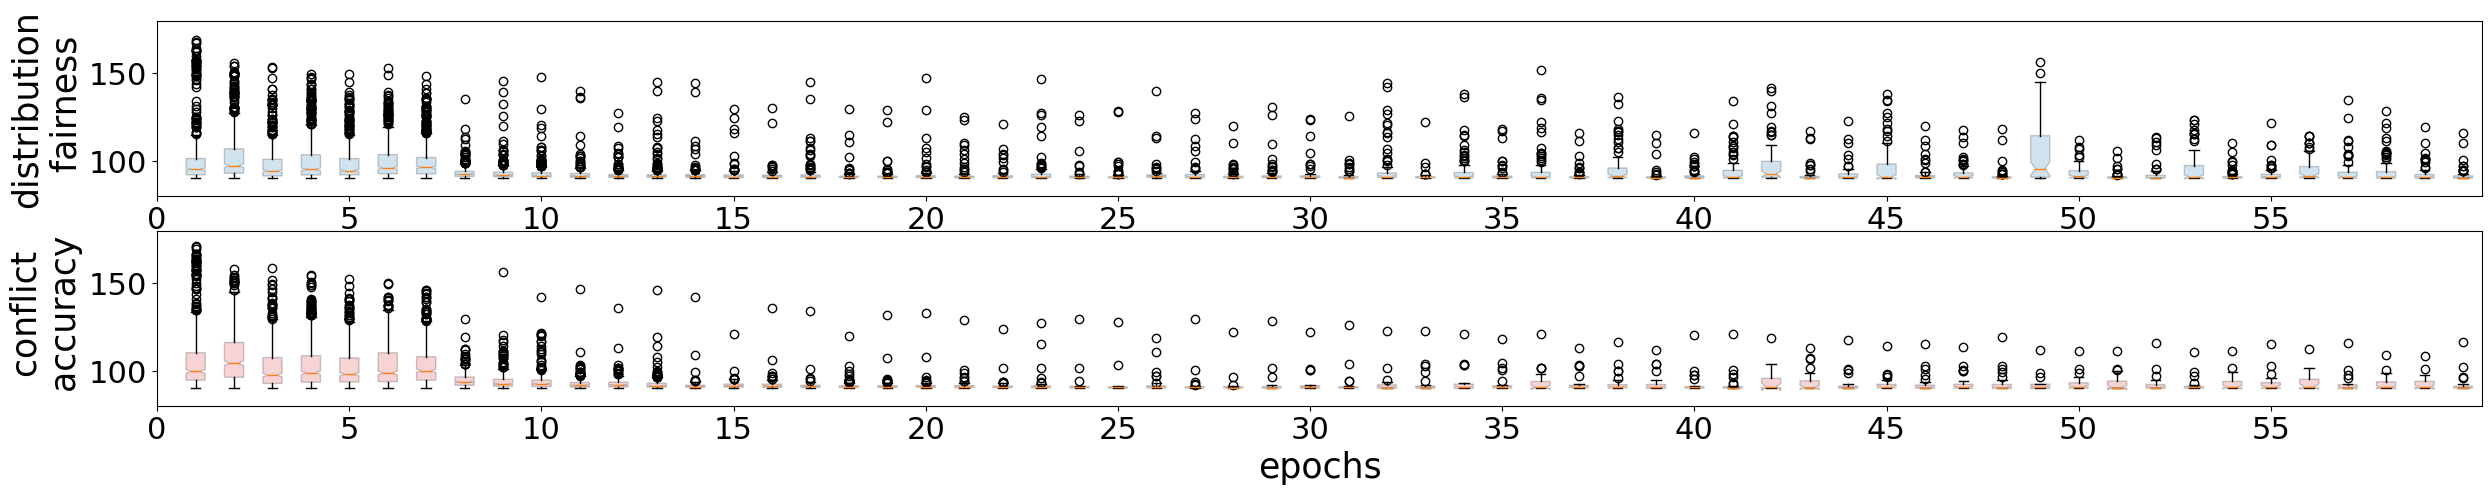

In [10]:
bx_p=[]
plt.rcParams.update({'font.size': 22})
lb=np.arange(0,60,5)
for epoch in range(len(conflicts)):
    cnf=[]
    for c in conflicts[epoch]:
        cnf+=c 
    bx_p.append([v for v in cnf if v>90])
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(30,5))
ax[0].set_ylim(80,180)
bp=ax[0].boxplot(bx_p,notch=True, patch_artist=True)
for patch in bp['boxes']:
    patch.set_alpha(0.2)
    patch.set_facecolor('tab:blue')
ax[0].set_xlabel('epochs',fontsize=25)
ax[0].set_ylabel('distribution\n fairness',fontsize=25)
ax[0].set_xticks(lb)
ax[0].set_xticklabels(lb)
bx_p=[]
for epoch in range(len(conflicts)):
    cnf=[]
    for c in aconflicts[epoch]:
        cnf+=c 
    bx_p.append([v for v in cnf if v>90])
#fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(30,5))
ax[1].set_ylim(80,180)
bp=ax[1].boxplot(bx_p,notch=True, patch_artist=True)
for patch in bp['boxes']:
    patch.set_alpha(0.2)
    patch.set_facecolor('tab:red')
ax[1].set_xlabel('epochs',fontsize=25)
ax[1].set_ylabel('  conflict \n accuracy',fontsize=25)
ax[1].set_xticks(lb)
ax[1].set_xticklabels(lb)
#plt.ylabel('conflict distribution',fontsize=25,loc='center')
#plt.yaxis.set_label_coords(-0.1,1.02)

#plt.xticks(np.arange(0,37,5))
#ax.set_xticklabels(np.arange(0,131,5))
plt.show()

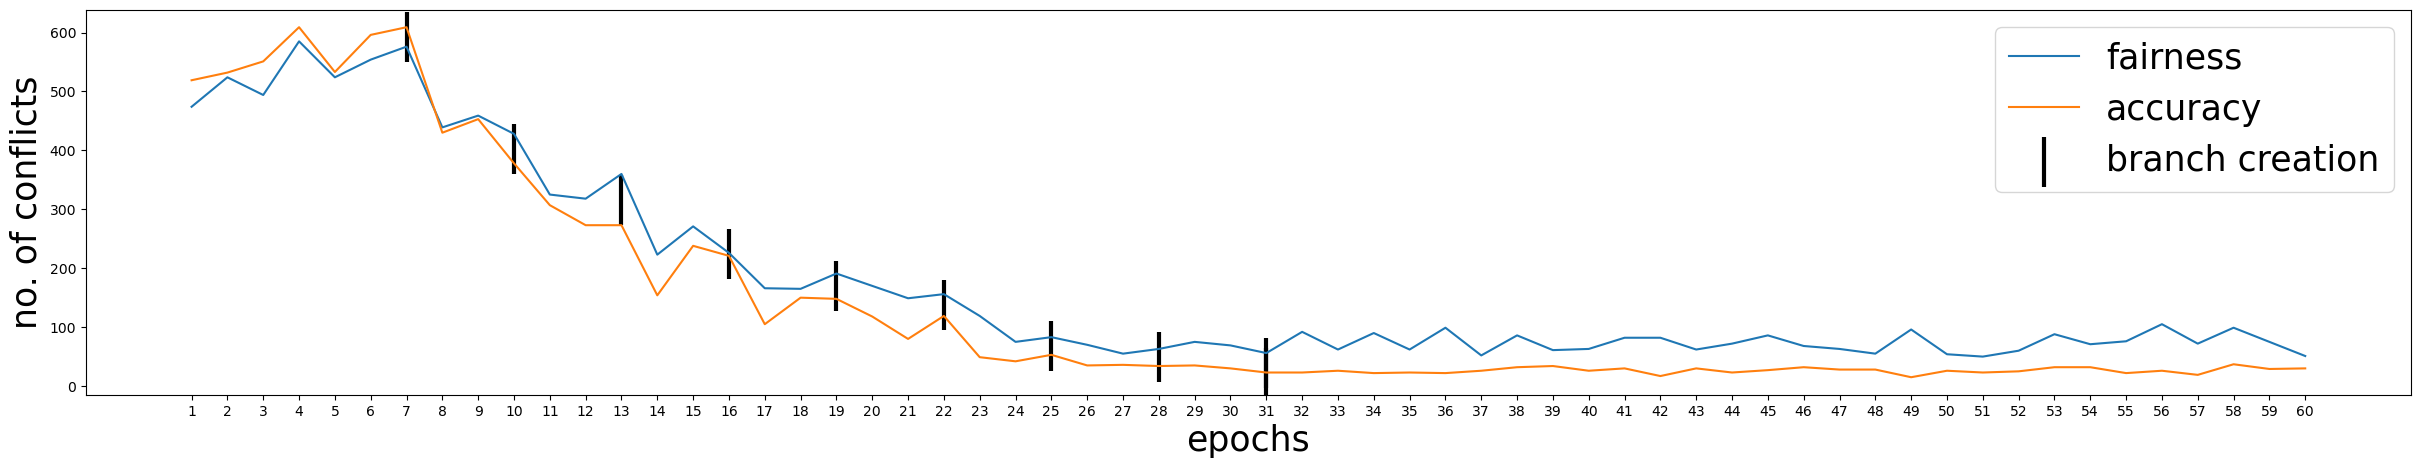

In [37]:
fig, ax = plt.subplots(figsize=(30,5))

lanp=[]
for epoch in range(len(conflicts)):
    cnf=[]
    for c in conflicts[epoch]:
        cnf+=c 
    lanp.append(len([v for v in cnf if v>90]))
ax.plot(lanp,label='fairness')
lnp=[]
for epoch in range(len(conflicts)):
    cnf=[]
    for c in aconflicts[epoch]:
        cnf+=c 
    lnp.append(len([v for v in cnf if v>90]))

#ax.set_ylim(100,500)
ax.plot(lnp,label='accuracy')
for m in range(6,6+8*3+1,3):
    ax.scatter(m,(lnp[m]+lanp[m])/2, marker='|',s=11**3,linewidth=3,color='black')
ax.scatter(m,lnp[m], marker='|',s=11**3,linewidth=3,color='black',label='branch creation')
ax.set_xlabel('epochs',fontsize=25)
ax.set_ylabel('no. of conflicts',fontsize=25)
plt.xticks(np.arange(0,60))
labs=np.arange(0,60)
labs+=1
ax.set_xticklabels(labs)
plt.legend(loc='upper right', fontsize=25)
plt.show()

In [14]:
f_heat=torch.load(prefix+'f_heat.pt')
a_heat=torch.load(prefix+'a_heat.pt')
Ft=load_celeba(protected='Gender',return_ft=True)

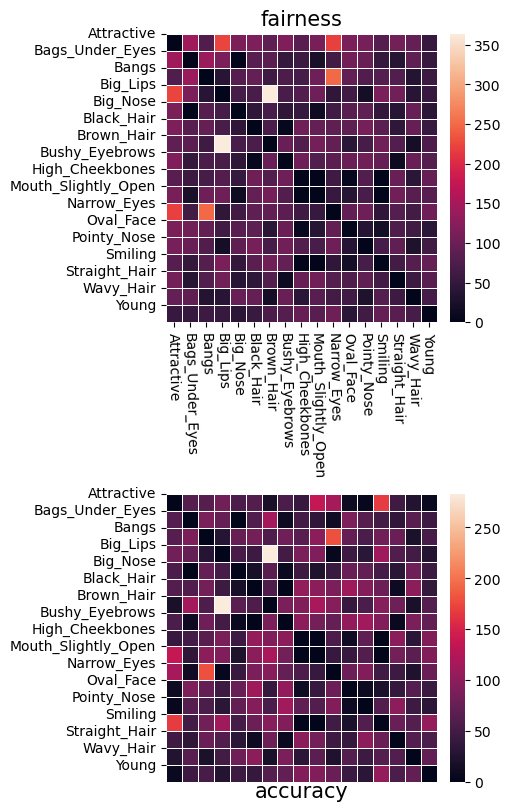

In [34]:
import seaborn as sns
fig, axes = plt.subplots(2, 1, figsize=(5, 8),layout='constrained')
ax1 = sns.heatmap(ax=axes[0],data=f_heat, linewidth=0.5)
ax1.set_xticklabels(Ft,rotation=-89)
ax1.set_yticks(np.arange(0,len(f_heat)))
ax1.set_yticklabels(Ft,rotation=-0)#set_yticklabels([])
ax1.set_title('fairness',fontsize=15)
ax2 = sns.heatmap(ax=axes[1],data=a_heat, linewidth=0.5)
ax2.set_xticks([])
ax2.set_xticklabels([])#Ft,rotation=-89)

ax2.set_yticks(np.arange(0,len(f_heat)))
ax2.set_yticklabels(Ft,rotation=-0)
ax2.set_title('accuracy',y=-0.08, fontsize=15)
plt.show()

In [9]:
fb,conflicts,heats=trainFBvission(model_pre,dataset='CelebA',protected='Age')

0 :  Time: 1.1216530799865723
Time: 2.3086493015289307
Epoch:  0 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12, 23], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [24], [25], [26], [27], [28], [29], [30]] at Layer 1
Task 0   Acc: tensor(0.8833) EO: (tensor(0.0134), tensor(0.0039))
Task 1   Acc: tensor(0.7425) EO: (tensor(0.0082), tensor(0.0072))
Task 2   Acc: tensor(0.4794) EO: (tensor(0.0292), tensor(0.0195))
Task 3   Acc: tensor(0.7890) EO: (tensor(0.0090), tensor(0.0065))
Task 4   Acc: tensor(0.8506) EO: (tensor(0.0202), tensor(0.0136))
Task 5   Acc: tensor(0.8484) EO: (tensor(0.0343), tensor(0.0314))
Task 6   Acc: tensor(0.7483) EO: (tensor(0.0201), tensor(0.0175))
Task 7   Acc: tensor(0.7930) EO: (tensor(0.0265), tensor(0.0154))
Task 8   Acc: tensor(0.8496) EO: (tensor(0.0115), tensor(0.0105))
Task 9   Acc: tensor(0.7575) EO: (tensor(0.0398), tensor(0.0259))
Task 10   Acc: tensor(0.8591) EO: (tensor(0.0118), tensor(0.0020))
Task 

4 :  Time: 1.0515213012695312
Time: 1.8071093559265137
Epoch:  4 Possible groups: [[0], [1], [2], [3], [4, 29], [5], [6, 7], [8, 27], [9, 25], [10], [11], [12], [13], [14, 20], [15], [16], [17], [18], [19], [21], [22], [23], [24], [26], [28], [30]] at Layer 1
Task 0   Acc: tensor(0.8833) EO: (tensor(0.0134), tensor(0.0039))
Task 1   Acc: tensor(0.7458) EO: (tensor(0.0038), tensor(0.0020))
Task 2   Acc: tensor(0.6267) EO: (tensor(0.0323), tensor(0.0221))
Task 3   Acc: tensor(0.7890) EO: (tensor(0.0090), tensor(0.0065))
Task 4   Acc: tensor(0.8506) EO: (tensor(0.0202), tensor(0.0136))
Task 5   Acc: tensor(0.8484) EO: (tensor(0.0343), tensor(0.0314))
Task 6   Acc: tensor(0.7483) EO: (tensor(0.0201), tensor(0.0175))
Task 7   Acc: tensor(0.7930) EO: (tensor(0.0265), tensor(0.0154))
Task 8   Acc: tensor(0.8496) EO: (tensor(0.0115), tensor(0.0105))
Task 9   Acc: tensor(0.7575) EO: (tensor(0.0398), tensor(0.0259))
Task 10   Acc: tensor(0.8591) EO: (tensor(0.0118), tensor(0.0020))
Task 11   Acc

8 :  Time: 0.9583282470703125
Time: 1.596785306930542
Epoch:  8 Possible groups: [[0], [1], [2], [3], [4], [5, 23], [6], [7], [8], [9], [10, 11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [24], [25], [26]] at Layer 2
Task 0   Acc: tensor(0.8833) EO: (tensor(0.0134), tensor(0.0039))
Task 1   Acc: tensor(0.7547) EO: (tensor(0.0072), tensor(0.0069))
Task 2   Acc: tensor(0.6625) EO: (tensor(0.0601), tensor(0.0342))
Task 3   Acc: tensor(0.7890) EO: (tensor(0.0090), tensor(0.0065))
Task 4   Acc: tensor(0.8506) EO: (tensor(0.0202), tensor(0.0136))
Task 5   Acc: tensor(0.8467) EO: (tensor(0.0357), tensor(0.0330))
Task 6   Acc: tensor(0.7472) EO: (tensor(0.0233), tensor(0.0215))
Task 7   Acc: tensor(0.7930) EO: (tensor(0.0265), tensor(0.0154))
Task 8   Acc: tensor(0.8907) EO: (tensor(0.0620), tensor(0.0577))
Task 9   Acc: tensor(0.7575) EO: (tensor(0.0398), tensor(0.0259))
Task 10   Acc: tensor(0.8591) EO: (tensor(0.0118), tensor(0.0020))
Task 11   Acc: tensor(0.9296) EO

Epoch:  12 Possible groups: [[0, 11], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25]] at Layer 4
Task 0   Acc: tensor(0.8806) EO: (tensor(0.0076), tensor(0.0067))
Task 1   Acc: tensor(0.7537) EO: (tensor(0.0140), tensor(0.0114))
Task 2   Acc: tensor(0.6865) EO: (tensor(0.0073), tensor(0.0020))
Task 3   Acc: tensor(0.7962) EO: (tensor(0.0126), tensor(0.0011))
Task 4   Acc: tensor(0.8617) EO: (tensor(0.0504), tensor(0.0407))
Task 5   Acc: tensor(0.8470) EO: (tensor(0.0144), tensor(0.0120))
Task 6   Acc: tensor(0.7697) EO: (tensor(0.0261), tensor(0.0248))
Task 7   Acc: tensor(0.8099) EO: (tensor(0.0099), tensor(0.0011))
Task 8   Acc: tensor(0.8984) EO: (tensor(0.0099), tensor(0.0046))
Task 9   Acc: tensor(0.7721) EO: (tensor(0.0484), tensor(0.0379))
Task 10   Acc: tensor(0.8580) EO: (tensor(0.0162), tensor(0.0129))
Task 11   Acc: tensor(0.9312) EO: (tensor(0.0148), tensor(0.0128))
Task 12   Acc: tensor(

Epoch:  16 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22]] at Layer 5
Task 0   Acc: tensor(0.8834) EO: (tensor(0.0180), tensor(0.0077))
Task 1   Acc: tensor(0.7615) EO: (tensor(0.0072), tensor(0.0054))
Task 2   Acc: tensor(0.6941) EO: (tensor(0.0444), tensor(0.0057))
Task 3   Acc: tensor(0.7890) EO: (tensor(0.0090), tensor(0.0065))
Task 4   Acc: tensor(0.8692) EO: (tensor(0.0382), tensor(0.0297))
Task 5   Acc: tensor(0.8503) EO: (tensor(0.0386), tensor(0.0365))
Task 6   Acc: tensor(0.7676) EO: (tensor(0.0307), tensor(0.0265))
Task 7   Acc: tensor(0.8254) EO: (tensor(0.0271), tensor(0.0253))
Task 8   Acc: tensor(0.9081) EO: (tensor(0.0450), tensor(0.0376))
Task 9   Acc: tensor(0.7788) EO: (tensor(0.0081), tensor(0.0066))
Task 10   Acc: tensor(0.8623) EO: (tensor(0.0168), tensor(0.0062))
Task 11   Acc: tensor(0.9296) EO: (tensor(0.0216), tensor(0.0134))
Task 12   Acc: tensor(0.9257) EO: (ten

Epoch:  20 Possible groups: [[0], [1, 11], [2], [3], [4], [5], [6], [7, 8], [9], [10], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22]] at Layer 6
Task 0   Acc: tensor(0.8807) EO: (tensor(0.0074), tensor(0.0067))
Task 1   Acc: tensor(0.7631) EO: (tensor(0.0234), tensor(0.0091))
Task 2   Acc: tensor(0.7023) EO: (tensor(0.0381), tensor(0.0260))
Task 3   Acc: tensor(0.7961) EO: (tensor(0.0188), tensor(0.0052))
Task 4   Acc: tensor(0.8784) EO: (tensor(0.0374), tensor(0.0265))
Task 5   Acc: tensor(0.8483) EO: (tensor(0.0102), tensor(0.0074))
Task 6   Acc: tensor(0.7709) EO: (tensor(0.0276), tensor(0.0247))
Task 7   Acc: tensor(0.8202) EO: (tensor(0.0118), tensor(0.0087))
Task 8   Acc: tensor(0.9052) EO: (tensor(0.0095), tensor(0.0022))
Task 9   Acc: tensor(0.7787) EO: (tensor(0.0363), tensor(0.0204))
Task 10   Acc: tensor(0.8621) EO: (tensor(0.0021), tensor(0.0009))
Task 11   Acc: tensor(0.9323) EO: (tensor(0.0112), tensor(0.0104))
Task 12   Acc: tensor(0.9272) EO: (tensor(

Epoch:  24 Possible groups: [[0], [1, 11], [2], [3], [4], [5], [6], [7], [8], [9], [10], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22]] at Layer 8
Task 0   Acc: tensor(0.8808) EO: (tensor(0.0122), tensor(0.0109))
Task 1   Acc: tensor(0.7597) EO: (tensor(0.0225), tensor(0.0099))
Task 2   Acc: tensor(0.7071) EO: (tensor(0.0347), tensor(0.0246))
Task 3   Acc: tensor(0.7970) EO: (tensor(0.0224), tensor(0.0118))
Task 4   Acc: tensor(0.8775) EO: (tensor(0.0459), tensor(0.0340))
Task 5   Acc: tensor(0.8457) EO: (tensor(0.0304), tensor(0.0257))
Task 6   Acc: tensor(0.7709) EO: (tensor(0.0230), tensor(0.0217))
Task 7   Acc: tensor(0.8194) EO: (tensor(0.0039), tensor(3.5405e-05))
Task 8   Acc: tensor(0.9075) EO: (tensor(0.0097), tensor(0.0066))
Task 9   Acc: tensor(0.7842) EO: (tensor(0.0370), tensor(0.0214))
Task 10   Acc: tensor(0.8612) EO: (tensor(0.0154), tensor(0.0153))
Task 11   Acc: tensor(0.9328) EO: (tensor(0.0107), tensor(0.0106))
Task 12   Acc: tensor(0.9270) EO: (t

Epoch:  28 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21]] at Layer 8
Task 0   Acc: tensor(0.8818) EO: (tensor(0.0045), tensor(0.0043))
Task 1   Acc: tensor(0.7613) EO: (tensor(0.0239), tensor(0.0111))
Task 2   Acc: tensor(0.7074) EO: (tensor(0.0360), tensor(0.0200))
Task 3   Acc: tensor(0.7959) EO: (tensor(0.0238), tensor(0.0139))
Task 4   Acc: tensor(0.8765) EO: (tensor(0.0372), tensor(0.0349))
Task 5   Acc: tensor(0.8509) EO: (tensor(0.0180), tensor(0.0173))
Task 6   Acc: tensor(0.7742) EO: (tensor(0.0328), tensor(0.0259))
Task 7   Acc: tensor(0.8247) EO: (tensor(0.0217), tensor(0.0211))
Task 8   Acc: tensor(0.9075) EO: (tensor(0.0099), tensor(0.0026))
Task 9   Acc: tensor(0.7826) EO: (tensor(0.0292), tensor(0.0129))
Task 10   Acc: tensor(0.8634) EO: (tensor(0.0125), tensor(0.0119))
Task 11   Acc: tensor(0.9345) EO: (tensor(0.0108), tensor(0.0085))
Task 12   Acc: tensor(0.9276) EO: (tensor(0.

Epoch:  32 Possible groups: [[0, 19], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [20], [21]] at Layer 8
Task 0   Acc: tensor(0.8823) EO: (tensor(0.0131), tensor(0.0111))
Task 1   Acc: tensor(0.7636) EO: (tensor(0.0225), tensor(0.0094))
Task 2   Acc: tensor(0.7023) EO: (tensor(0.0330), tensor(0.0262))
Task 3   Acc: tensor(0.7990) EO: (tensor(0.0217), tensor(0.0095))
Task 4   Acc: tensor(0.8814) EO: (tensor(0.0161), tensor(0.0125))
Task 5   Acc: tensor(0.8502) EO: (tensor(0.0177), tensor(0.0166))
Task 6   Acc: tensor(0.7721) EO: (tensor(0.0301), tensor(0.0279))
Task 7   Acc: tensor(0.8261) EO: (tensor(0.0050), tensor(0.0047))
Task 8   Acc: tensor(0.9104) EO: (tensor(0.0087), tensor(0.0042))
Task 9   Acc: tensor(0.7810) EO: (tensor(0.0363), tensor(0.0184))
Task 10   Acc: tensor(0.8619) EO: (tensor(0.0095), tensor(0.0085))
Task 11   Acc: tensor(0.9354) EO: (tensor(0.0103), tensor(0.0065))
Task 12   Acc: tensor(0.9270) EO: (tensor(0.05

Epoch:  36 Possible groups: [[0, 19], [1], [2], [3, 8], [4], [5], [6], [7], [9], [10], [11], [12], [13], [14], [15], [16, 17], [18], [20], [21]] at Layer 8
Task 0   Acc: tensor(0.8803) EO: (tensor(0.0089), tensor(0.0080))
Task 1   Acc: tensor(0.7563) EO: (tensor(0.0419), tensor(0.0239))
Task 2   Acc: tensor(0.6956) EO: (tensor(0.0101), tensor(0.0077))
Task 3   Acc: tensor(0.7856) EO: (tensor(0.0365), tensor(0.0231))
Task 4   Acc: tensor(0.8814) EO: (tensor(0.0244), tensor(0.0236))
Task 5   Acc: tensor(0.8357) EO: (tensor(0.0438), tensor(0.0395))
Task 6   Acc: tensor(0.7684) EO: (tensor(0.0422), tensor(0.0387))
Task 7   Acc: tensor(0.8261) EO: (tensor(0.0394), tensor(0.0384))
Task 8   Acc: tensor(0.9059) EO: (tensor(0.0173), tensor(0.0118))
Task 9   Acc: tensor(0.7806) EO: (tensor(0.0206), tensor(0.0083))
Task 10   Acc: tensor(0.8598) EO: (tensor(0.0106), tensor(0.0096))
Task 11   Acc: tensor(0.9341) EO: (tensor(0.0182), tensor(0.0128))
Task 12   Acc: tensor(0.9247) EO: (tensor(0.0622),

Epoch:  40 Possible groups: [[0, 19], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16, 17], [18], [20], [21]] at Layer 8
Task 0   Acc: tensor(0.8752) EO: (tensor(0.0053), tensor(0.0051))
Task 1   Acc: tensor(0.7563) EO: (tensor(0.0138), tensor(0.0053))
Task 2   Acc: tensor(0.6836) EO: (tensor(0.0292), tensor(0.0147))
Task 3   Acc: tensor(0.7943) EO: (tensor(0.0234), tensor(0.0130))
Task 4   Acc: tensor(0.8748) EO: (tensor(0.0249), tensor(0.0237))
Task 5   Acc: tensor(0.8252) EO: (tensor(0.0248), tensor(0.0234))
Task 6   Acc: tensor(0.7629) EO: (tensor(0.0413), tensor(0.0351))
Task 7   Acc: tensor(0.8189) EO: (tensor(0.0344), tensor(0.0285))
Task 8   Acc: tensor(0.9077) EO: (tensor(0.0052), tensor(0.0002))
Task 9   Acc: tensor(0.7758) EO: (tensor(0.0391), tensor(0.0310))
Task 10   Acc: tensor(0.8555) EO: (tensor(0.0236), tensor(0.0204))
Task 11   Acc: tensor(0.9341) EO: (tensor(0.0182), tensor(0.0128))
Task 12   Acc: tensor(0.9206) EO: (tensor(0.0437

Epoch:  44 Possible groups: [[0, 19], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [20], [21]] at Layer 8
Task 0   Acc: tensor(0.8740) EO: (tensor(0.0121), tensor(0.0106))
Task 1   Acc: tensor(0.7483) EO: (tensor(0.0162), tensor(0.0111))
Task 2   Acc: tensor(0.6740) EO: (tensor(0.0202), tensor(0.0161))
Task 3   Acc: tensor(0.7845) EO: (tensor(0.0299), tensor(0.0130))
Task 4   Acc: tensor(0.8710) EO: (tensor(0.0097), tensor(0.0033))
Task 5   Acc: tensor(0.8118) EO: (tensor(0.0250), tensor(0.0219))
Task 6   Acc: tensor(0.7523) EO: (tensor(0.0302), tensor(0.0244))
Task 7   Acc: tensor(0.8129) EO: (tensor(0.0202), tensor(0.0174))
Task 8   Acc: tensor(0.9031) EO: (tensor(0.0134), tensor(0.0075))
Task 9   Acc: tensor(0.7728) EO: (tensor(0.0346), tensor(0.0263))
Task 10   Acc: tensor(0.8496) EO: (tensor(0.0328), tensor(0.0317))
Task 11   Acc: tensor(0.9312) EO: (tensor(0.0264), tensor(0.0215))
Task 12   Acc: tensor(0.9230) EO: (tensor(0.04

Epoch:  48 Possible groups: [[0, 19], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [20], [21]] at Layer 8
Task 0   Acc: tensor(0.8765) EO: (tensor(0.0260), tensor(0.0196))
Task 1   Acc: tensor(0.7532) EO: (tensor(0.0142), tensor(0.0055))
Task 2   Acc: tensor(0.6898) EO: (tensor(0.0480), tensor(0.0174))
Task 3   Acc: tensor(0.7694) EO: (tensor(0.0069), tensor(0.0050))
Task 4   Acc: tensor(0.8651) EO: (tensor(0.0131), tensor(0.0095))
Task 5   Acc: tensor(0.8064) EO: (tensor(0.0601), tensor(0.0532))
Task 6   Acc: tensor(0.7452) EO: (tensor(0.0240), tensor(0.0010))
Task 7   Acc: tensor(0.8117) EO: (tensor(0.0133), tensor(0.0047))
Task 8   Acc: tensor(0.9015) EO: (tensor(0.0420), tensor(0.0414))
Task 9   Acc: tensor(0.7649) EO: (tensor(0.0290), tensor(0.0231))
Task 10   Acc: tensor(0.8449) EO: (tensor(0.0219), tensor(0.0102))
Task 11   Acc: tensor(0.9325) EO: (tensor(0.0215), tensor(0.0153))
Task 12   Acc: tensor(0.9195) EO: (tensor(0.01

Epoch:  52 Possible groups: [[0, 19], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [20], [21]] at Layer 8
Task 0   Acc: tensor(0.8734) EO: (tensor(0.0062), tensor(0.0049))
Task 1   Acc: tensor(0.7486) EO: (tensor(0.0242), tensor(0.0150))
Task 2   Acc: tensor(0.6822) EO: (tensor(0.0063), tensor(0.0060))
Task 3   Acc: tensor(0.7745) EO: (tensor(0.0216), tensor(0.0101))
Task 4   Acc: tensor(0.8647) EO: (tensor(0.0377), tensor(0.0351))
Task 5   Acc: tensor(0.7947) EO: (tensor(0.0506), tensor(0.0394))
Task 6   Acc: tensor(0.7514) EO: (tensor(0.0507), tensor(0.0410))
Task 7   Acc: tensor(0.8131) EO: (tensor(0.0282), tensor(0.0186))
Task 8   Acc: tensor(0.8984) EO: (tensor(0.0123), tensor(0.0046))
Task 9   Acc: tensor(0.7678) EO: (tensor(0.0211), tensor(0.0082))
Task 10   Acc: tensor(0.8453) EO: (tensor(0.0057), tensor(0.0027))
Task 11   Acc: tensor(0.9323) EO: (tensor(0.0256), tensor(0.0191))
Task 12   Acc: tensor(0.9222) EO: (tensor(0.05

Epoch:  56 Possible groups: [[0, 19], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [20], [21]] at Layer 8
Task 0   Acc: tensor(0.8698) EO: (tensor(0.0316), tensor(0.0250))
Task 1   Acc: tensor(0.7416) EO: (tensor(0.0416), tensor(0.0383))
Task 2   Acc: tensor(0.6642) EO: (tensor(0.0809), tensor(0.0390))
Task 3   Acc: tensor(0.7621) EO: (tensor(0.0051), tensor(0.0042))
Task 4   Acc: tensor(0.8575) EO: (tensor(0.0032), tensor(0.0021))
Task 5   Acc: tensor(0.7765) EO: (tensor(0.0650), tensor(0.0543))
Task 6   Acc: tensor(0.7357) EO: (tensor(0.0271), tensor(0.0168))
Task 7   Acc: tensor(0.8073) EO: (tensor(0.0230), tensor(0.0214))
Task 8   Acc: tensor(0.9035) EO: (tensor(0.0403), tensor(0.0352))
Task 9   Acc: tensor(0.7584) EO: (tensor(0.0319), tensor(0.0274))
Task 10   Acc: tensor(0.8398) EO: (tensor(0.0225), tensor(0.0076))
Task 11   Acc: tensor(0.9300) EO: (tensor(0.0208), tensor(0.0134))
Task 12   Acc: tensor(0.9189) EO: (tensor(0.01

In [11]:
dir_path='/yourpath/Grouping_FMTL/models/'
prefix=dir_path+'CelebA'+'_'+'Age'+'_'
conflicts=torch.load(prefix+'conflicts.pt')
aconflicts=torch.load(prefix+'aconflicts.pt')

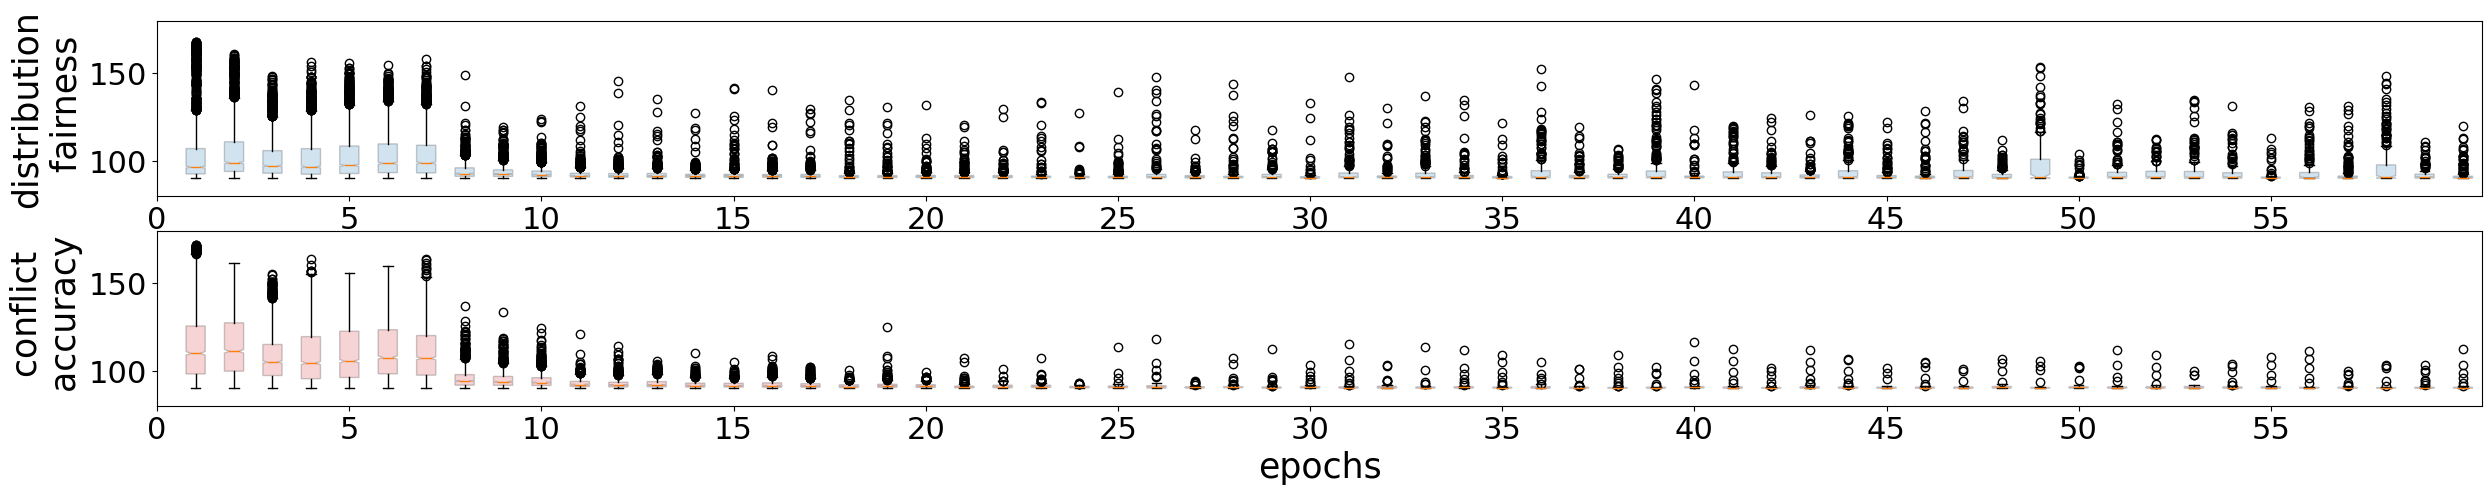

In [12]:
bx_p=[]
plt.rcParams.update({'font.size': 22})
lb=np.arange(0,60,5)
for epoch in range(len(conflicts)):
    cnf=[]
    for c in conflicts[epoch]:
        cnf+=c 
    bx_p.append([v for v in cnf if v>90])
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(30,5))
ax[0].set_ylim(80,180)
bp=ax[0].boxplot(bx_p,notch=True, patch_artist=True)
for patch in bp['boxes']:
    patch.set_alpha(0.2)
    patch.set_facecolor('tab:blue')
ax[0].set_xlabel('epochs',fontsize=25)
ax[0].set_ylabel('distribution\n fairness',fontsize=25)
ax[0].set_xticks(lb)
ax[0].set_xticklabels(lb)
bx_p=[]
for epoch in range(len(conflicts)):
    cnf=[]
    for c in aconflicts[epoch]:
        cnf+=c 
    bx_p.append([v for v in cnf if v>90])
#fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(30,5))
ax[1].set_ylim(80,180)
bp=ax[1].boxplot(bx_p,notch=True, patch_artist=True)
for patch in bp['boxes']:
    patch.set_alpha(0.2)
    patch.set_facecolor('tab:red')
ax[1].set_xlabel('epochs',fontsize=25)
ax[1].set_ylabel('  conflict \n accuracy',fontsize=25)
ax[1].set_xticks(lb)
ax[1].set_xticklabels(lb)
#plt.ylabel('conflict distribution',fontsize=25,loc='center')
#plt.yaxis.set_label_coords(-0.1,1.02)

#plt.xticks(np.arange(0,37,5))
#ax.set_xticklabels(np.arange(0,131,5))
plt.show()

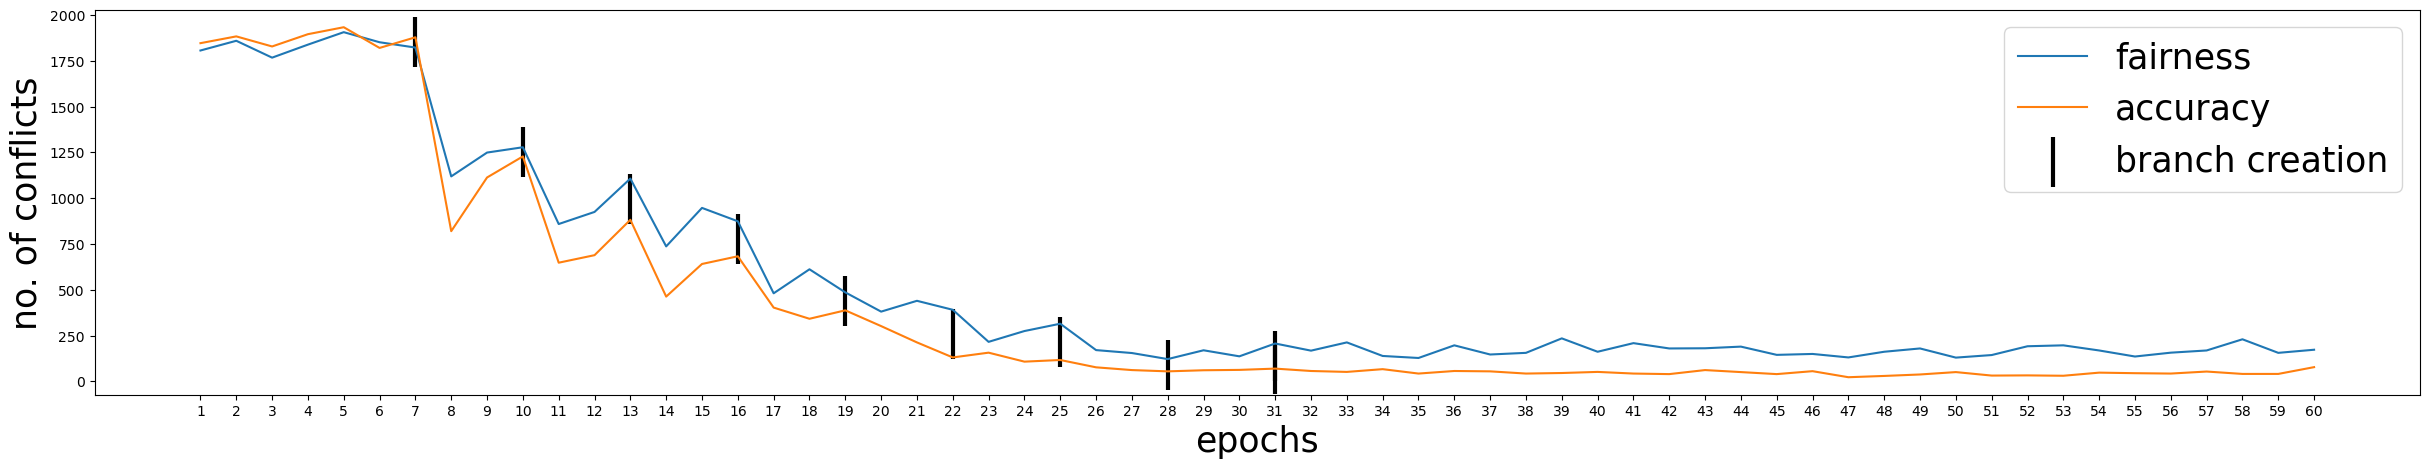

In [40]:
fig, ax = plt.subplots(figsize=(30,5))

lanp=[]
for epoch in range(len(conflicts)):
    cnf=[]
    for c in conflicts[epoch]:
        cnf+=c 
    lanp.append(len([v for v in cnf if v>90]))
ax.plot(lanp,label='fairness')
lnp=[]
for epoch in range(len(conflicts)):
    cnf=[]
    for c in aconflicts[epoch]:
        cnf+=c 
    lnp.append(len([v for v in cnf if v>90]))

#ax.set_ylim(100,500)
ax.plot(lnp,label='accuracy')
for m in range(6,6+8*3+1,3):
    ax.scatter(m,(lnp[m]+lanp[m])/2, marker='|',s=11**3,linewidth=3,color='black')
ax.scatter(m,lnp[m], marker='|',s=11**3,linewidth=3,color='black',label='branch creation')
ax.set_xlabel('epochs',fontsize=25)
ax.set_ylabel('no. of conflicts',fontsize=25)
plt.xticks(np.arange(0,60))
labs=np.arange(0,60)
labs+=1
ax.set_xticklabels(labs)
plt.legend(loc='upper right', fontsize=25)
plt.show()

In [40]:
f_heat=torch.load(prefix+'f_heat.pt')
a_heat=torch.load(prefix+'a_heat.pt')


In [41]:
Ft=load_celeba(protected='Age',return_ft=True)

In [45]:
len(a_heat)

31

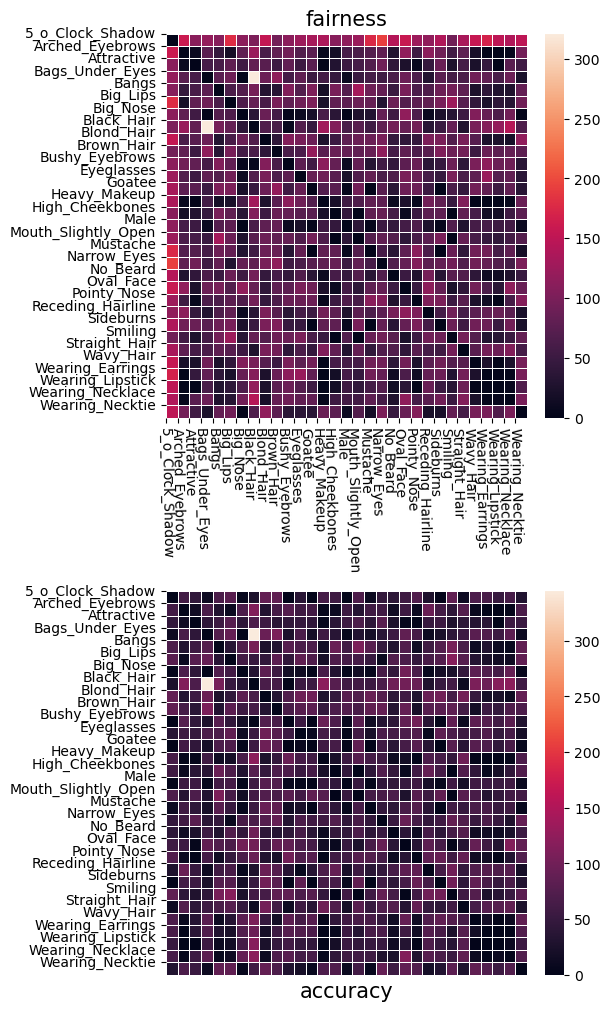

In [54]:

import seaborn as sns
fig, axes = plt.subplots(2, 1, figsize=(6, 10),layout='constrained')
ax1 = sns.heatmap(ax=axes[0],data=f_heat, linewidth=0.5)
ax1.set_xticks(np.arange(0,len(f_heat)))
ax1.set_xticklabels(Ft,rotation=-89)
ax1.set_yticks(np.arange(0,len(f_heat)))
ax1.set_yticklabels(Ft,rotation=-0)#set_yticklabels([])
ax1.set_title('fairness',fontsize=15)
ax2 = sns.heatmap(ax=axes[1],data=a_heat, linewidth=0.5)
ax2.set_xticks([])
ax2.set_xticklabels([])#Ft,rotation=-89)

ax2.set_yticks(np.arange(0,len(f_heat)))
ax2.set_yticklabels(Ft,rotation=-0)
ax2.set_title('accuracy',y=-0.08, fontsize=15)
plt.show()

In [16]:
dataloader_test, y_test, g_test=load_celeba(protected='Age',mode='test')
fb.to(dv)
test_batch=next(iter(dataloader_test))[0]
pred0=fb(test_batch.to(dv).float())
N_tasks=len(y_test)

In [17]:
for t in range(N_tasks):  
    accuracy=acc(pred0[t].to(cpu),torch.tensor(y_test[t]).to(cpu))
    EO=DM_rate(pred0[t].to(cpu),torch.tensor(y_test[t]).to(cpu),torch.tensor(g_test).to(cpu))
    print('Task',t,'  Acc:',accuracy, 'EO:',EO)


Task 0   Acc: tensor(0.8738) EO: (tensor(0.0723), tensor(0.0666))
Task 1   Acc: tensor(0.7257) EO: (tensor(0.0173), tensor(0.0130))
Task 2   Acc: tensor(0.6909) EO: (tensor(0.0112), tensor(0.0037))
Task 3   Acc: tensor(0.7412) EO: (tensor(0.0194), tensor(0.0160))
Task 4   Acc: tensor(0.8625) EO: (tensor(0.0116), tensor(0.0090))
Task 5   Acc: tensor(0.6554) EO: (tensor(0.0091), tensor(0.0089))
Task 6   Acc: tensor(0.7505) EO: (tensor(0.0318), tensor(0.0315))
Task 7   Acc: tensor(0.7800) EO: (tensor(0.0192), tensor(0.0132))
Task 8   Acc: tensor(0.9045) EO: (tensor(0.0078), tensor(0.0070))
Task 9   Acc: tensor(0.7876) EO: (tensor(0.0321), tensor(0.0237))
Task 10   Acc: tensor(0.8405) EO: (tensor(0.0047), tensor(0.0019))
Task 11   Acc: tensor(0.9330) EO: (tensor(0.0046), tensor(0.0044))
Task 12   Acc: tensor(0.9322) EO: (tensor(0.0043), tensor(0.0039))
Task 13   Acc: tensor(0.7620) EO: (tensor(0.0178), tensor(0.0082))
Task 14   Acc: tensor(0.6451) EO: (tensor(0.0133), tensor(0.0084))
Task 